<h1><center>APTOS 2019 Blindness Detection</center></h1>
<h2><center>Blindness Detection in Diabetic patients-
using Deep Learning
</center></h2>

Millions of people suffer from diabetic retinopathy, the leading cause of blindness among working aged adults. It is a diabetes complication that affects the eyes. Currently, technicians travel to rural areas in India to capture images and then rely on highly trained doctors to review the images and provide diagnosis. Their goal is to scale their efforts through technology; to gain the ability to automatically screen images for disease and provide information on how severe the condition may be.

<br> 
<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/APTOS%202019%20Blindness%20Detection/aux_img.png"></center>

We have a large set of retina images under a variety of imaging conditions from Aravind Eye Hospital, India. This is pre classified but needs processing. Then a machine learning model needs to be built using this labeled data to classify future images. Keras is a powerful and easy-to-use free open source Python library for developing and evaluating deep learning models. It wraps the efficient numerical computation libraries TensorFlow and allows us to define and train neural network models efficiently.



In [2]:
#Importing Libraries

import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

Using TensorFlow backend.


## Data 
We have a large set of retina images under a variety of imaging conditions from Aravind Eye Hospital, India. The dataset consists of about 3662 retinal images. Each image has been rated for the severity of diabetic retinopathy on a scale of 0 to 4:

0 - No Diabetic retinopathy <br>
1 - Mild <br>
2 - Moderate <br>
3 - Severe <br>
4 - Proliferative Diabetic retinopathy


In [3]:
#Load the data
train_df = pd.read_csv('aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('aptos2019-blindness-detection/test.csv')

### Data overview

In [4]:
print('Number of train samples: ', train_df.shape[0])
print('Number of test samples: ', test_df.shape[0])
display(train_df.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


### Label class distribution


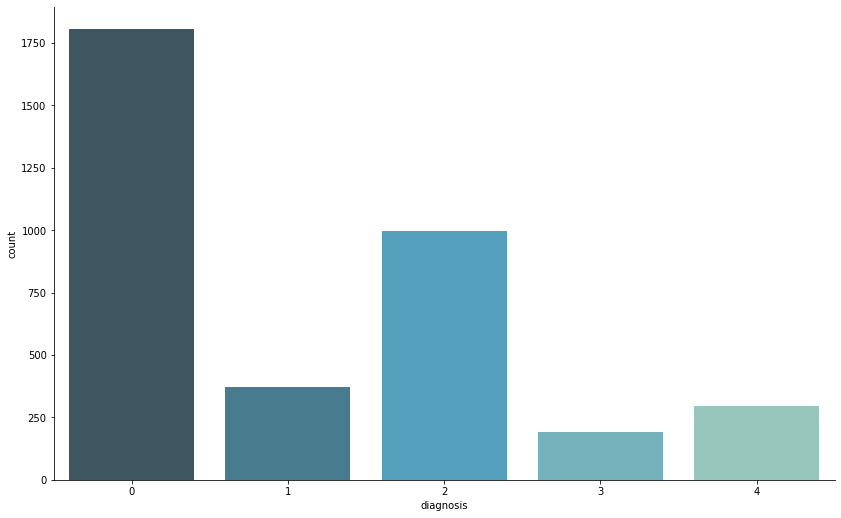

In [5]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train_df, palette="GnBu_d")
sns.despine()
plt.show()

## Preprocessing

We first take at the original input data randomly picking five images from each class. The images below display retinal scans where each row depicts each severity level. 


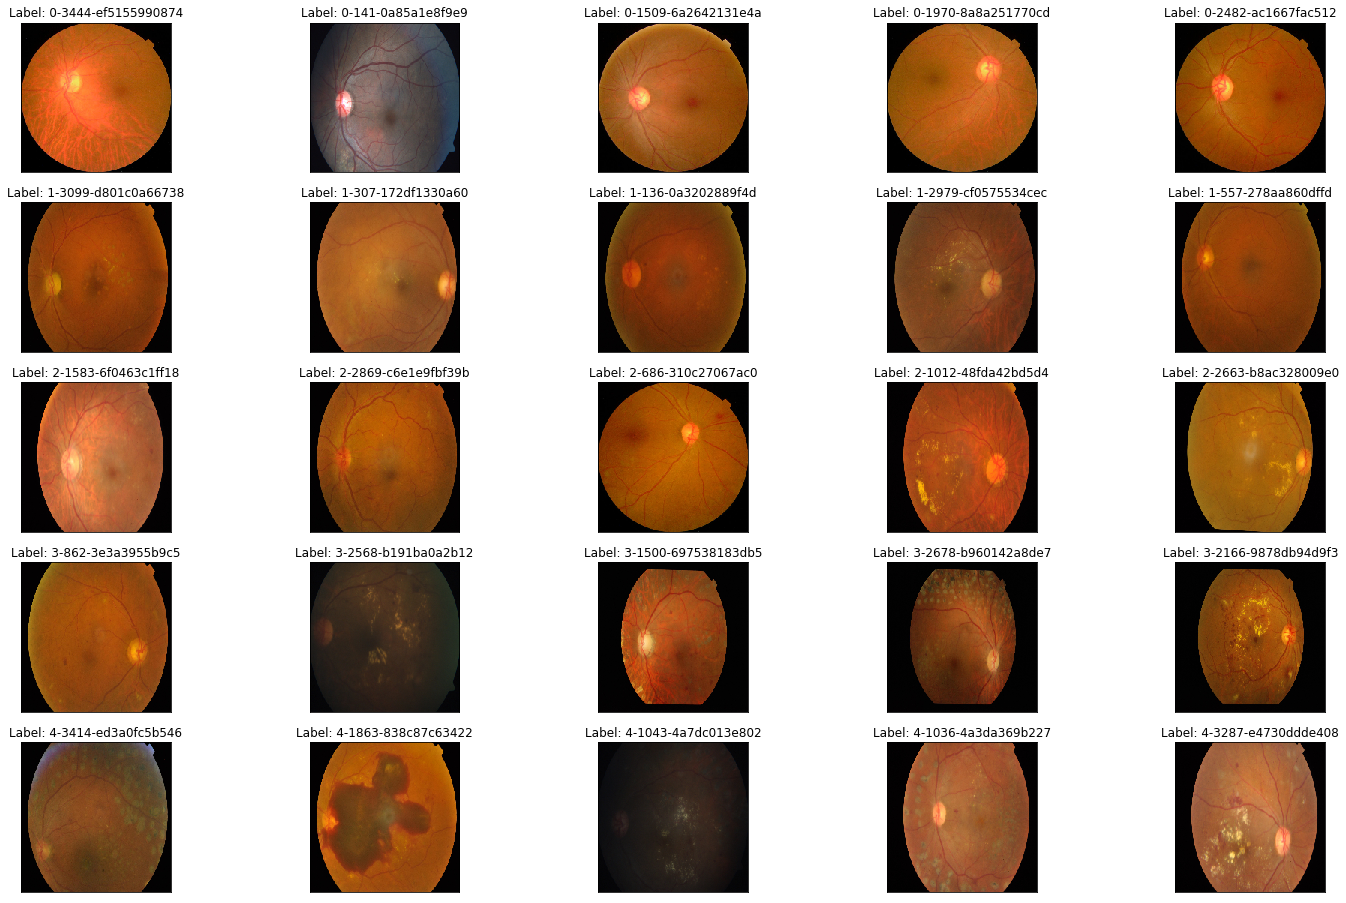

In [6]:
fig = plt.figure(figsize=(25, 16))
# display 5 images from each class
for class_id in sorted(train_df['diagnosis'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(5, random_state=42).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (200,200 ))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )
        

We can see two problems which make the severity category difficult to spot.
First, some images are very dark [example: second pic in the 4th row] and sometimes different color of illumination/background is confusing [example: second pic in the first row]. 
Second, we can get the uninformative dark areas for some pictures [example: third and fourth pic in the fourth row]. 
This is important when we reduce the picture size, as informative areas become too small. So, it is intuitive to crop the uninformative areas out in the second case.


### Grayscaling 
We can try gray scale and feel understand better for some pictures, as color distraction is gone. Considering the first ten from above: 
 

### Gaussian Blur
In image processing, a Gaussian blur (also known as Gaussian smoothing) is the result of blurring an image by a Gaussian function. It is a widely used effect in graphics software, typically to reduce image noise and reduce detail.
Gaussian smoothing is also used as a pre-processing stage in computer vision algorithms in order to enhance image structures at different scales—see scale space representation and scale space implementation.
Using this technique on the images results in the following:


# Model parameters

In [7]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 20
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 512
WIDTH = 512
CANAL = 3
N_CLASSES = train_df['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [8]:
# Preprocecss data
train_df["id_code"] = train_df["id_code"].apply(lambda x: x + ".png")
test_df["id_code"] = test_df["id_code"].apply(lambda x: x + ".png")
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


## Data generator

In [9]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 horizontal_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH),
    subset='training')

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",    
    target_size=(HEIGHT, WIDTH),
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test_df,
        directory = "aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# Model Building

In [10]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights('keras-pretrained-models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

In [11]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

C:\Users\priya\anaconda3.7\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

# Train top layers

In [12]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=WARMUP_EPOCHS,
                              verbose=1).history

Epoch 1/2
366/366 [==============================] - 2698s 7s/step - loss: 1.2555 - accuracy: 0.6383 - val_loss: 3.1965 - val_accuracy: 0.4615
Epoch 2/2
366/366 [==============================] - 7486s 20s/step - loss: 0.8085 - accuracy: 0.7053 - val_loss: 3.3888 - val_accuracy: 0.4627


# Fine-tune the complete model

In [13]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metric_list)


In [27]:
history_finetunning = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=1).history

Epoch 1/20
366/366 [==============================] - 8061s 22s/step - loss: 0.2542 - accuracy: 0.8992 - val_loss: 0.9286 - val_accuracy: 0.7846
Epoch 2/20
366/366 [==============================] - 7454s 20s/step - loss: 0.1949 - accuracy: 0.9179 - val_loss: 1.1133 - val_accuracy: 0.8006
Epoch 3/20
366/366 [==============================] - 8801s 24s/step - loss: 0.1833 - accuracy: 0.9245 - val_loss: 0.2465 - val_accuracy: 0.9108
Epoch 4/20
366/366 [==============================] - 7392s 20s/step - loss: 0.1627 - accuracy: 0.9305 - val_loss: 0.0413 - val_accuracy: 0.8959
Epoch 5/20
366/366 [==============================] - 8551s 23s/step - loss: 0.1512 - accuracy: 0.9352 - val_loss: 0.2322 - val_accuracy: 0.9215
Epoch 6/20
366/366 [==============================] - 9055s 25s/step - loss: 0.1429 - accuracy: 0.9417 - val_loss: 0.1553 - val_accuracy: 0.9262
Epoch 7/20
366/366 [==============================] - 37036s 101s/step - loss: 0.1203 - accuracy: 0.9513 - val_loss: 0.0461 - val_

# Model loss graph 

In [45]:
model_json = model.to_json()
with open("model_resnet.json", "w") as json_file:
    json_file.write(model_json)
model.save("model_resnet50_final.h5")

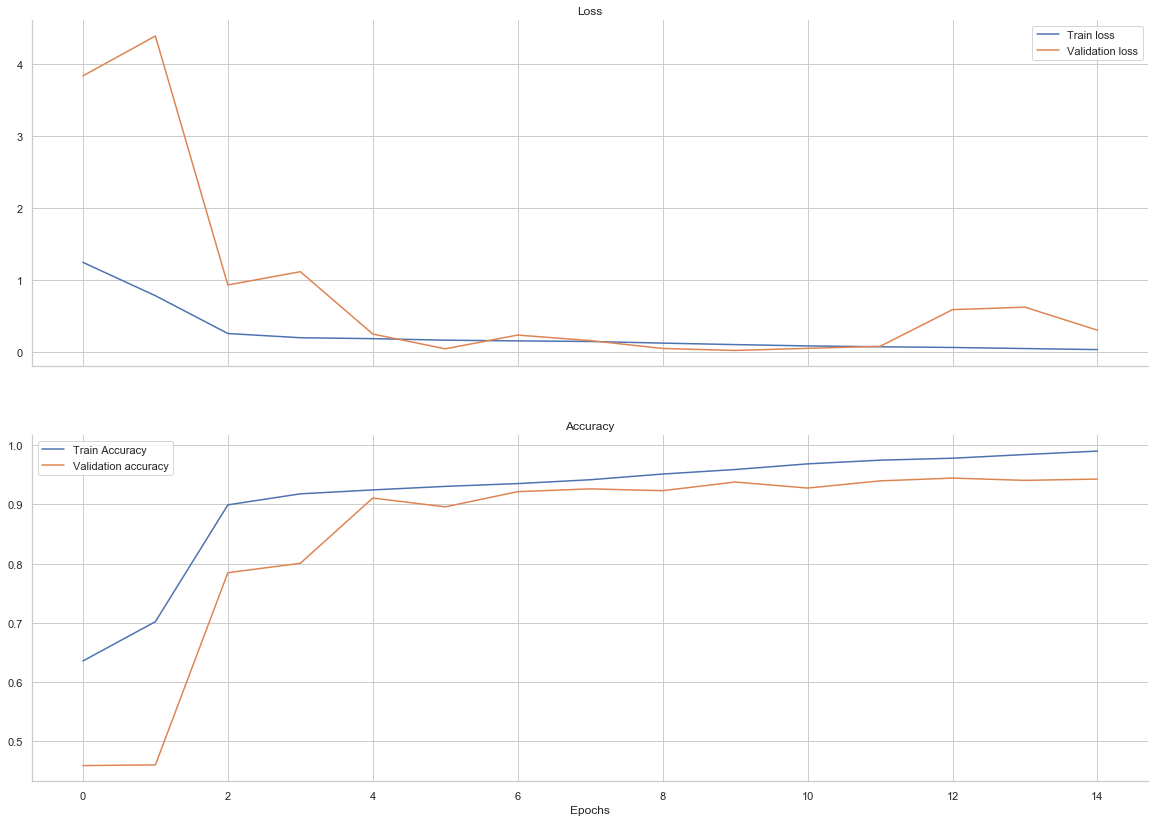

In [32]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['accuracy'] + history_finetunning['accuracy'], 
           'val_acc': history_warmup['val_accuracy'] + history_finetunning['val_accuracy']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train Accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model Evaluation

In [35]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(  
        dataframe=train_df,
        directory = "aptos2019-blindness-detection/train_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 3662 validated image filenames.


## Confusion Matrix

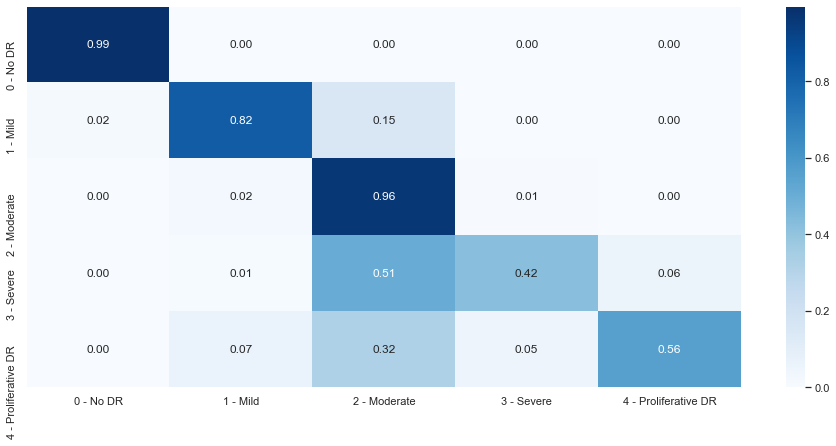

In [36]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(train_df['diagnosis'].astype('int'), train_preds)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

## Quadratic Weighted Kappa

In [37]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_df['diagnosis'].astype('int'), weights='quadratic'))

Train Cohen Kappa score: 0.924


# Apply model to test set and output predictions

In [38]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

In [40]:
filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,2
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2
5,009c019a7309,2
6,010d915e229a,2
7,0111b949947e,2
8,01499815e469,3
9,0167076e7089,0


## Predictions class distribution

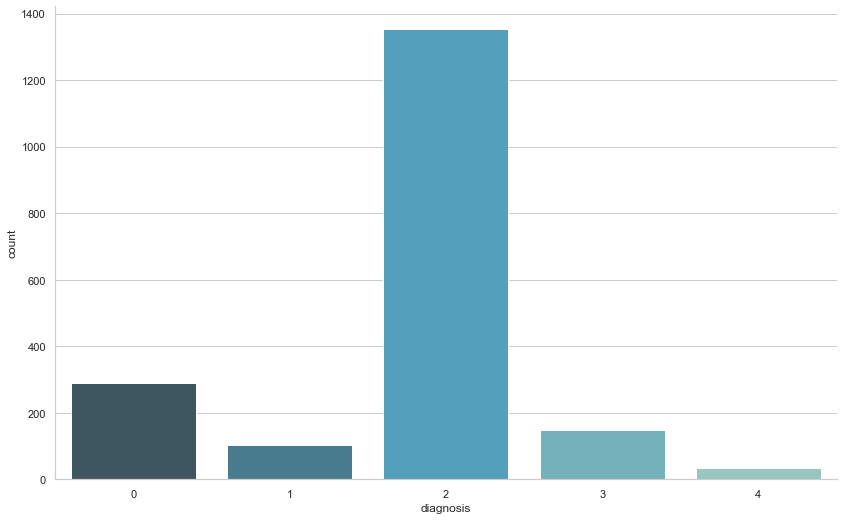

In [42]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()